In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from orbit.models.dlt import DLTMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.utils.features import make_fourier_series_df
from orbit.utils.stan import estimate_level_smoothing, get_compiled_stan_model

import pystan

In [2]:
df = pd.read_csv('./data/m5_agg_demand_full.csv', parse_dates=['date'])
# get a subset of regressor for demo purpose
regressor_col = ["Christmas","Halloween","LaborDay","Thanksgiving","Mother's day","PresidentsDay","NewYear"]
df, fs_cols = make_fourier_series_df(df, 'date', period=365, order=3)

In [3]:
df = df[["date", "sales"] + fs_cols + regressor_col]
df['sales'] = np.log(df['sales'])
df.head(5)

,date,sales,fs_cos1,fs_sin1,fs_cos2,fs_sin2,fs_cos3,fs_sin3,Christmas,Halloween,LaborDay,Thanksgiving,Mother's day,PresidentsDay,NewYear
0,2011-01-29,10.393018,0.674444,0.738326,0.995919,0.090252,0.796183,-0.605056,0,0,0,0,0,0,0
1,2011-01-30,10.365617,0.687053,0.726608,0.998435,0.055917,0.763889,-0.645348,0,0,0,0,0,0,0
2,2011-01-31,10.076726,0.699458,0.714673,0.999769,0.021516,0.729558,-0.683919,0,0,0,0,0,0,0
3,2011-02-01,10.142977,0.711657,0.702527,0.999917,-0.012910,0.693281,-0.720667,0,0,0,0,0,0,0
4,2011-02-02,9.859849,0.723644,0.690173,0.998880,-0.047321,0.655156,-0.755493,0,0,0,0,0,0,0


In [4]:
test_size = 28
train_df = df[:-test_size]
test_df = df[-test_size:]

0.999999999999999


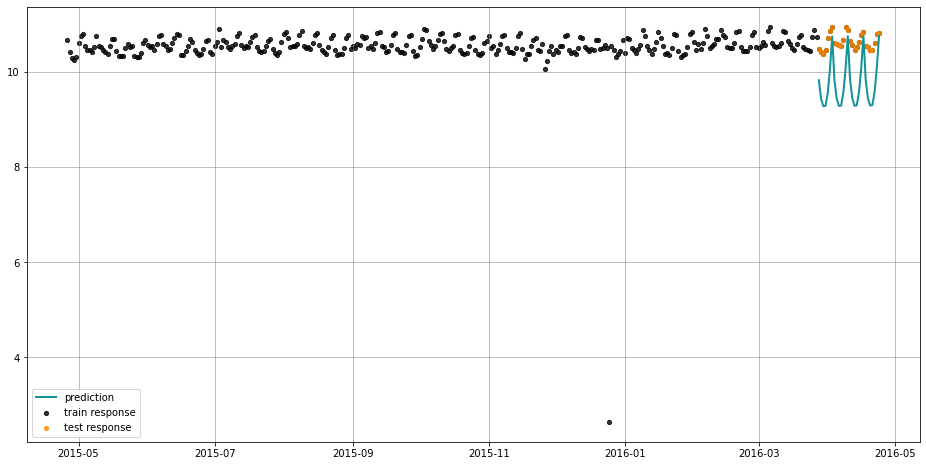

In [5]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols,
    regressor_sigma_prior=[0.5] * (len(fs_cols)),
    regression_penalty='lasso',
    period=365,
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)

print(dlt._posterior_samples['lev_sm'])
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')



0.999999999999999


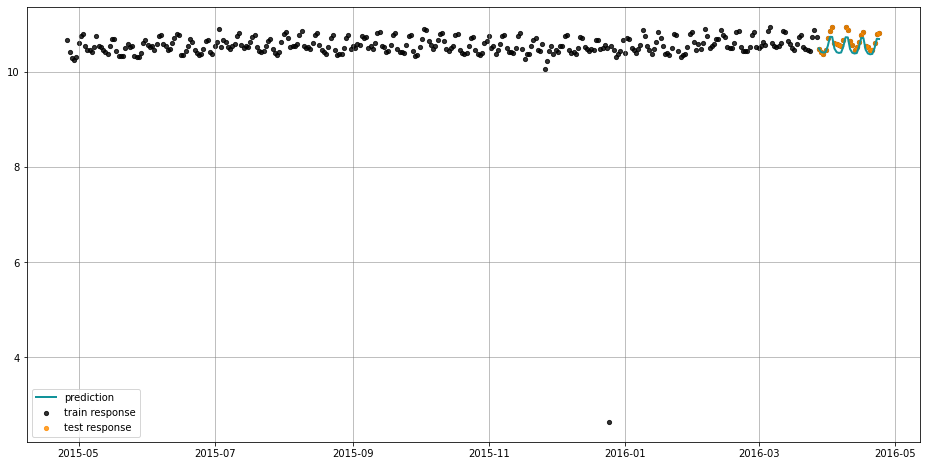

In [6]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols,
    regressor_sigma_prior=[0.5] * (len(fs_cols)),
   # regression_penalty='lasso',
    period=365,
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)

print(dlt._posterior_samples['lev_sm'])
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')

0.5980657820793195


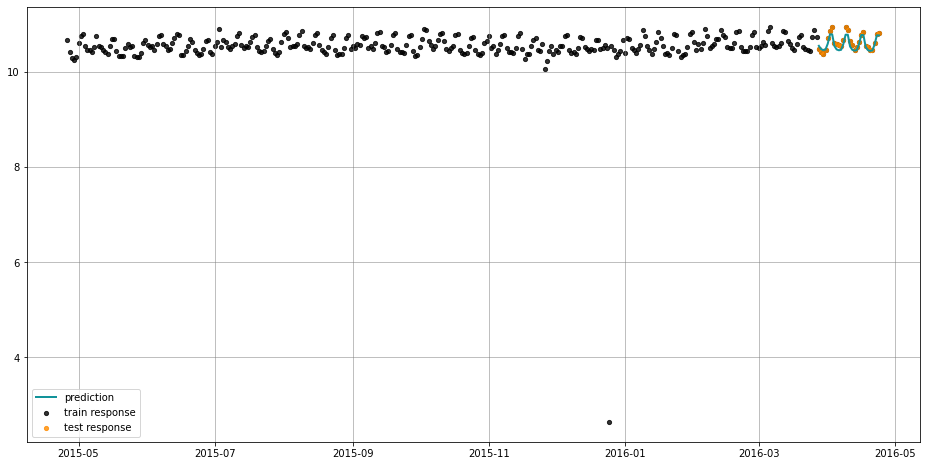

In [7]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    regressor_col=fs_cols + regressor_col,
    regressor_sigma_prior=[0.5] * (len(fs_cols)+len(regressor_col)),
    regression_penalty='lasso',
    period=365,
)

dlt.fit(train_df)
predicted_df = dlt.predict(test_df)

print(dlt._posterior_samples['lev_sm'])
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')

In high frequency data, default DLT yields very bad result mainly due to mixed level smoothing parameters estimation.  We can see the estimated smoothing parameter yields a boundary condition.

In [20]:
derived_lev_sm = estimate_level_smoothing(train_df['sales'].values, seasonality=365)

In [21]:
derived_lev_sm

array(0.0001)

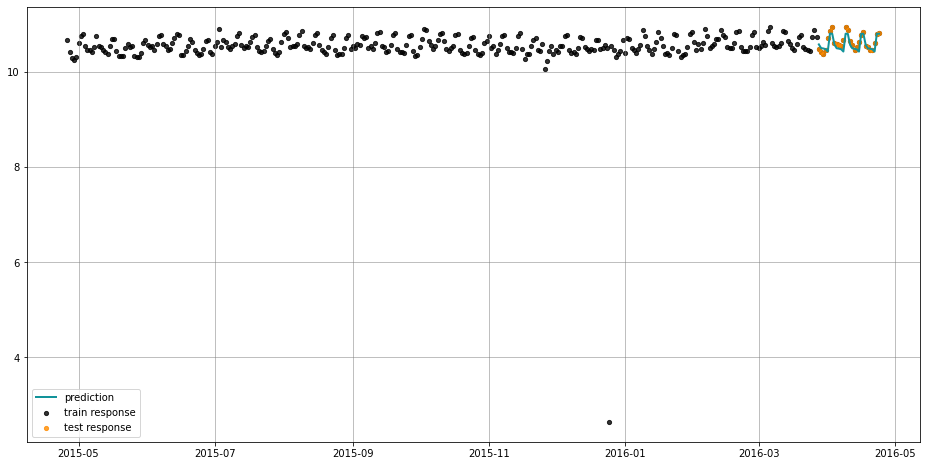

In [22]:
dlt = DLTMAP(
    response_col='sales',
    date_col='date',
    seasonality=7,
    seed=2020,
    level_sm_input=derived_lev_sm,
    slope_sm_input=derived_lev_sm,
    regressor_col=fs_cols,
    regressor_sigma_prior=[0.5] * len(fs_cols),
    regression_penalty='lasso',
    period=365,
)
dlt.fit(train_df)
predicted_df = dlt.predict(test_df)
plot_predicted_data(training_actual_df=df[-365:], predicted_df=predicted_df[-90:], 
                    test_actual_df=test_df, date_col=dlt.date_col,
                    actual_col='sales', pred_col='prediction')